,Id,Category,Artists,Track,Version,Duration,Artists_Genres,Album,Release_year,Album_type,Labels,Key,BPM,Vocal,Country,Energy,Dancebility,Happiness
0,0,0.0,Avatar,Hail the Apocalypse,NaN,253660,metal,Hail the Apocalypse,2014,NaN,Gain,F# Major,93,M,SWE,99.0,42.0,30.0
1,1,1.0,Céline Dion,My Heart Will Go On,Soundtrack,284150,soundtrack|classical|pop,My Love Ultimate Essential Collection,2019,NaN,Sony Music Entertainment Canada,E Major,99,F,CA,28.0,43.0,4.0
2,2,1.0,Adele,Skyfall,Soundtrack,286480,pop,Skyfall,2012,single,Melted Stone|Skyfall|Columbia,C Minor,76,F,GB,55.0,35.0,8.0
3,3,1.0,Kiss,I Was Made for Lovin' You,Soundtrack,268440,hardrock|rock|foreignrap,KISS Box Set,2001,NaN,The Island Def Jam,E Major,128,M,USA,85.0,77.0,87.0
4,4,0.0,Kanye West,Stronger,NaN,311420,foreignrap,Graduation,2007,NaN,A Roc-A-Fella Records release,B♭ Minor,104,M,USA,72.0,62.0,49.0


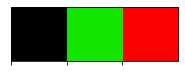

In [1]:
#Final project ----- Pier Luca Anania

#libraries
import pandas as pd
import seaborn as sns
import plotly.express as xp
import plotly.graph_objects as go
import numpy as np
from datetime import datetime
import missingno
import yaml
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV,ShuffleSplit
from sklearn.manifold import TSNE
from sklearn.linear_model import RidgeClassifier
from sklearn.impute import SimpleImputer

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

palette = ['#000000',"#13e600","#fc0000"]
sns.palplot(palette)

#import data
test = pd.read_csv('../input/my-musical-preferences-data/test.csv')
train = pd.read_csv('../input/my-musical-preferences-data/train.csv')
description = yaml.load(open("../input/description/Description.yaml",'r'),Loader=yaml.FullLoader)

music = pd.concat([train,test]).reset_index(drop=True)
tr_mask = ~music.Category.isna()
music.head()

In [2]:
#visualize type of data
train.info()
print('_'*40)
test.info()
#object ~ string
music.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665 entries, 0 to 664
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              665 non-null    int64  
 1   Category        665 non-null    int64  
 2   Artists         664 non-null    object 
 3   Track           665 non-null    object 
 4   Version         94 non-null     object 
 5   Duration        665 non-null    int64  
 6   Artists_Genres  665 non-null    object 
 7   Album           663 non-null    object 
 8   Release_year    665 non-null    int64  
 9   Album_type      139 non-null    object 
 10  Labels          660 non-null    object 
 11  Key             665 non-null    object 
 12  BPM             665 non-null    int64  
 13  Vocal           665 non-null    object 
 14  Country         658 non-null    object 
 15  Energy          664 non-null    float64
 16  Dancebility     664 non-null    float64
 17  Happiness       664 non-null    flo

<AxesSubplot:>

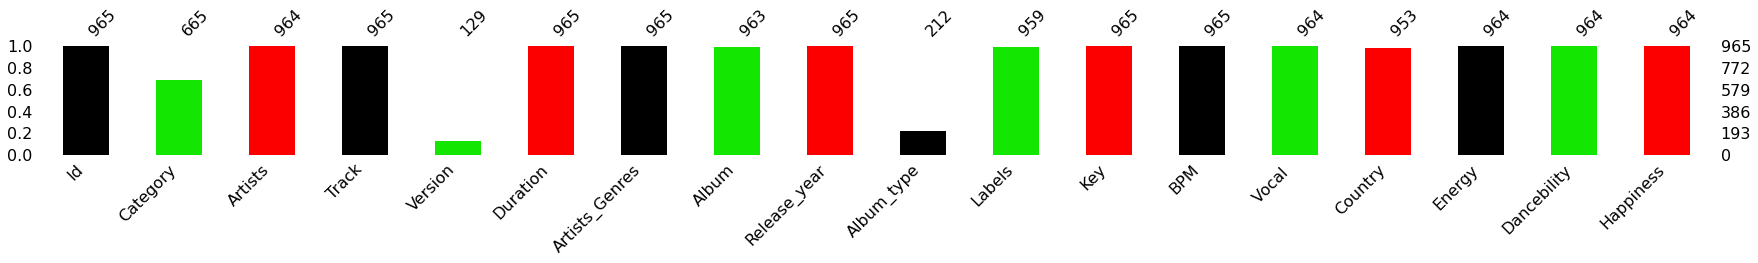

In [3]:
#other visualization of number of non null values in dataset music
missingno.bar(music, color=palette, figsize=(30,2))

**Data Preparation**

In [4]:
#Code to split in one hot  (nxn) with 0-1 elements
def split_to_onehot(df, col):
    """
    This method converts features separated by '|' into one-hot vectors.
    Additionally it drops unnecessary values, which present only in 
    test set / train set or have only one value.
    """
    # Getting all unique ganres values.
    unique = []
    for i in df.index:
        unique.extend(df.loc[i,col].split("|"))
    if "" in unique:
        unique.remove("")
    unique = list(set(unique))
    
    # Putting values into binary form 
    onehot = df.loc[:,["Category"]]
    onehot[unique] = np.zeros((len(unique),), dtype = np.int8)
    for i in df.index:
        g = set(df.loc[i,col].split("|"))
        for j in g:
            if j!="":
                onehot.loc[i,j] = 1

                              
    # Dropping unnecessary values            
    _a = onehot.groupby("Category").sum()
    only_one = list(_a.sum()[_a.sum()==1].index)
    only_train = list(_a.loc["none"][_a.loc["none"]==0].index)
    only_test = list(_a.loc[["like",'dislike']].sum()[_a.loc[["like",'dislike']].sum()==0].index)
    _a = set(only_one + only_train + only_test)
    onehot = onehot.drop(_a, axis=1)
    
    return onehot

**Preprocessing data**

In [5]:
#goal is to get the information in the categories column: 0-dislike, 1-like
print(music['Category'].unique())

music["Category"] = music["Category"].fillna("none").replace({0:"dislike",1:"like"})

music['Category'].unique()

[ 0.  1. nan]


array(['dislike', 'like', 'none'], dtype=object)

In [6]:
#as seen in graph above there are 129 non null object
print(music['Version'])
print(music['Version'].count())

0             NaN
1      Soundtrack
2      Soundtrack
3      Soundtrack
4             NaN
          ...    
960           NaN
961    Radio Edit
962           NaN
963           NaN
964           NaN
Name: Version, Length: 965, dtype: object
129


In [7]:
#replacing NaN with 'NA' object/string 
music["Version"] = music["Version"].fillna("NA")

label_encoder = LabelEncoder()
music.Version = label_encoder.fit_transform(music.Version)
music['Version'].unique()
music['Version'].unique()

array([0, 5, 2, 1, 3, 4])

In [8]:
#Album_type has 212 non null oblect, replace NaN with 'NA'  
music["Album_type"] = music["Album_type"].fillna("NA")
label_encoder = LabelEncoder()
music.Album_type = label_encoder.fit_transform(music.Album_type)
music['Album_type'].unique()
print(music['Album_type'].count())


965


In [9]:
#for Key using one hot I create a matrix of 0 and 1 if the note exists or not in the song
music[list(set(music["Key"].values))] = OneHotEncoder().fit_transform(music[["Key"]]).toarray()
label_encoder = LabelEncoder()
music.Key = label_encoder.fit_transform(music.Key)
music = music.drop("Key", axis=1)
music.columns
music #to check


,Id,Category,Artists,Track,Version,Duration,Artists_Genres,Album,Release_year,Album_type,Labels,BPM,Vocal,Country,Energy,Dancebility,Happiness,F# Minor,F Major,B Minor,G Minor,D Minor,D♭ Minor,E♭ Minor,F Minor,F# Major,D♭ Major,A♭ Major,E♭ Major,C Major,C Minor,D Major,A Major,B♭ Major,B♭ Minor,C# Minor,E Major,A Minor,E Minor,B Major,G Major,A♭ Minor
0,0,dislike,Avatar,Hail the Apocalypse,0,253660,metal,Hail the Apocalypse,2014,0,Gain,93,M,SWE,99.0,42.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,like,Céline Dion,My Heart Will Go On,5,284150,soundtrack|classical|pop,My Love Ultimate Essential Collection,2019,0,Sony Music Entertainment Canada,99,F,CA,28.0,43.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,like,Adele,Skyfall,5,286480,pop,Skyfall,2012,2,Melted Stone|Skyfall|Columbia,76,F,GB,55.0,35.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,like,Kiss,I Was Made for Lovin' You,5,268440,hardrock|rock|foreignrap,KISS Box Set,2001,0,The Island Def Jam,128,M,USA,85.0,77.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,dislike,Kanye West,Stronger,0,311420,foreignrap,Graduation,2007,0,A Roc-A-Fella Records release,104,M,USA,72.0,62.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,960,none,Ленинград,Кабриолет,0,161530,rusrock,Кабриолет,2019,2,ShnurOK / Первое музыкальное,132,M,RUS,82.0,75.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
961,961,none,Gorillaz,Rock The House,1,183640,indie,G-Sides,2002,0,Parlophone,172,M,GB,82.0,75.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
962,962,none,Guano Apes,Open Your Eyes,0,186520,rock|alternative,Planet Of The Apes - Best Of Guano Apes,2015,0,Gun,112,F,USA,96.0,63.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
963,963,none,The Chainsmokers|Coldplay,Something Just Like This,0,247620,electronics|rock|dance,Memories...Do Not Open,2017,0,Disruptor|Columbia,130,M,GB,63.0,62.0,45.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
#Replace Vocal with numerical value 0,1,2,3,4 
music['Vocal '] = music['Vocal '].fillna("NAN")  #nan into string before substitution
music.loc[:,'Vocal '] = music.loc[:,'Vocal '].replace({"M": 1, 'F': 2, 'F|M': 3, "N": 4,"NAN":0})
music['Vocal '].unique()  #to check

array([1, 2, 3, 4, 0])

In [11]:
#Energy,Happiness,Dancebility,BPM
#from music.info() I know that first 3 are float64 and BPM is int64
for k in ["Energy","Happiness","Dancebility","BPM"]:
    print(f"{k}:{description[k]}")
    
music.loc[:,['Energy','Happiness','Dancebility','BPM']].info()

Energy:{'description': 'Continuouse value, describing energy of the track', 'values': '0-100'}
Happiness:{'description': 'Continuouse value, describing happiness of the track', 'values': '0-100'}
Dancebility:{'description': 'Continuouse value, describing dancebility of the track', 'values': '0-100'}
BPM:{'description': 'Beats-Per-Minute - the measure of tempo', 'values': 'integer value from 0 to inf'}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 965 entries, 0 to 964
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Energy       964 non-null    float64
 1   Happiness    964 non-null    float64
 2   Dancebility  964 non-null    float64
 3   BPM          965 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 30.3 KB


In [12]:
#The SimpleImputer class provides basic strategies for imputing missing values
from sklearn.impute import SimpleImputer 
imputer = SimpleImputer()
dataclean = pd.DataFrame(imputer.fit_transform(music[['Energy', 'Happiness', 'Dancebility','BPM']]))
music[['Energy', 'Happiness', 'Dancebility','BPM']] = music[['Energy', 'Happiness', 'Dancebility','BPM']].fillna(0)
#before the 3 below had 964 non null object, I use Boolean operator to check
print(music['Energy'].count() == 965 )
print(music['Happiness'].count() == 965 )
print(music['Dancebility'].count() == 965 )

True
True
True


In [13]:
#Artists Genres, I do not have missing values but I must clean elements
music.loc[:, 'Artists_Genres']

0                         metal
1      soundtrack|classical|pop
2                           pop
3      hardrock|rock|foreignrap
4                    foreignrap
                 ...           
960                     rusrock
961                       indie
962            rock|alternative
963      electronics|rock|dance
964                        rock
Name: Artists_Genres, Length: 965, dtype: object

In [14]:
#as before I create a matrix with 0-1 with one hot for Artist_Genres
matrix = split_to_onehot(music, 'Artists_Genres')
matrix= matrix.drop("Category", axis=1)

music = pd.concat([music,matrix],axis=1)
music = music.drop("Artists_Genres", axis=1)

music.head()  #first 5 rows to check

,Id,Category,Artists,Track,Version,Duration,Album,Release_year,Album_type,Labels,BPM,Vocal,Country,Energy,Dancebility,Happiness,F# Minor,F Major,B Minor,G Minor,D Minor,D♭ Minor,E♭ Minor,F Minor,F# Major,D♭ Major,A♭ Major,E♭ Major,C Major,C Minor,D Major,A Major,B♭ Major,B♭ Minor,C# Minor,E Major,A Minor,E Minor,B Major,G Major,A♭ Minor,rusestrada,prog,punk,classicmetal,reggae,dnb,films,rock,electronics,soundtrack,hardrock,jazz,rusrap,blues,rap,kpop,indie,classicalmasterpieces,numetal,folk,newwave,classical,industrial,african,rnb,epicmetal,foreignrap,trance,latinfolk,holiday,house,soul,vocal,rusrock,ruspop,pop,alternative,ska,dance
0,0,dislike,Avatar,Hail the Apocalypse,0,253660,Hail the Apocalypse,2014,0,Gain,93,1,SWE,99.0,42.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,like,Céline Dion,My Heart Will Go On,5,284150,My Love Ultimate Essential Collection,2019,0,Sony Music Entertainment Canada,99,2,CA,28.0,43.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2,like,Adele,Skyfall,5,286480,Skyfall,2012,2,Melted Stone|Skyfall|Columbia,76,2,GB,55.0,35.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,3,like,Kiss,I Was Made for Lovin' You,5,268440,KISS Box Set,2001,0,The Island Def Jam,128,1,USA,85.0,77.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,4,dislike,Kanye West,Stronger,0,311420,Graduation,2007,0,A Roc-A-Fella Records release,104,1,USA,72.0,62.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
#Encode target labels with value between 0 and n_classes-1.

track_encoder = LabelEncoder()
music["Track"] = track_encoder.fit_transform(music["Track"])

country_encoder = LabelEncoder()
music.Country = music.Country.fillna("NA")
music["Country"] = country_encoder.fit_transform(music["Country"])

artists_encoder = LabelEncoder()
music.Artists = music.Artists.fillna("NA")
music["Artists"] = artists_encoder.fit_transform(music["Artists"])

album_encoder = LabelEncoder()
music.Album = music.Album.fillna("NA")
music["Album"] = album_encoder.fit_transform(music["Album"])

label_encoder = LabelEncoder()
music.Labels = music.Labels.fillna("NA")
music["Labels"] = label_encoder.fit_transform(music["Labels"])

music     #all elements (not Category) are numerical values


,Id,Category,Artists,Track,Version,Duration,Album,Release_year,Album_type,Labels,BPM,Vocal,Country,Energy,Dancebility,Happiness,F# Minor,F Major,B Minor,G Minor,D Minor,D♭ Minor,E♭ Minor,F Minor,F# Major,D♭ Major,A♭ Major,E♭ Major,C Major,C Minor,D Major,A Major,B♭ Major,B♭ Minor,C# Minor,E Major,A Minor,E Minor,B Major,G Major,A♭ Minor,rusestrada,prog,punk,classicmetal,reggae,dnb,films,rock,electronics,soundtrack,hardrock,jazz,rusrap,blues,rap,kpop,indie,classicalmasterpieces,numetal,folk,newwave,classical,industrial,african,rnb,epicmetal,foreignrap,trance,latinfolk,holiday,house,soul,vocal,rusrock,ruspop,pop,alternative,ska,dance
0,0,dislike,32,269,0,253660,221,2014,0,112,93,1,39,99.0,42.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,like,79,468,5,284150,357,2019,0,242,99,2,6,28.0,43.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2,like,15,625,5,286480,459,2012,2,172,76,2,16,55.0,35.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,3,like,208,342,5,268440,289,2001,0,265,128,1,42,85.0,77.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,4,dislike,199,670,0,311420,209,2007,0,9,104,1,42,72.0,62.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,960,none,473,876,0,161530,652,2019,2,235,132,1,35,82.0,75.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
961,961,none,135,575,1,183640,190,2002,0,200,172,1,16,82.0,75.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
962,962,none,157,510,0,186520,397,2015,0,122,112,2,42,96.0,63.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
963,963,none,377,642,0,247620,340,2017,0,85,130,1,16,63.0,62.0,45.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


**Model Selection**

In [16]:
#Classifier using Ridge regression.
#This classifier first converts the target values into {-1, 1} and then 
#treats the problem as a regression task (multi-output regression in the multiclass case).

x, y = music.loc[tr_mask].iloc[:,2:], music.loc[tr_mask,"Category"]
deploy = music.loc[~tr_mask].iloc[:,2:]

rc = RidgeClassifier()
grid = {"alpha" : [0.007,0.008,0.0085],"solver": ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
cv = ShuffleSplit(n_splits=10,random_state=0)   #Random permutation cross-validator, with 10 reshuffling and splitting iteration and 
clf = GridSearchCV(rc, grid, cv=cv)              # random state = 0 Controls the randomness of the training and testing indices produced. Pass an int for reproducible output across multiple function calls
clf.fit(x,y)                                   #GridSearchCV implements a “fit” and a “score” method. It also implements “score_samples”, “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

clf.best_estimator_
sample = pd.read_csv('../input/mymusicalpreferencesdata/sample_submition.csv')
sample["Category"] = clf.predict(deploy)
sample["Category"] = (sample["Category"]=="like").astype(int)
sample.to_csv("deploy.csv", index=False)

#Score of the model Rideg Classifier
rc.fit(x, y)
score = rc.score(x, y)
print('Score Rc:' , score)

#Score of  cross-validation training method to the model and check the training score.
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(rc, x, y, cv=cv)
print("CV average score: %.2f" % cv_scores.mean())

final = pd.read_csv('./deploy.csv')
final

Score Rc: 0.6932330827067669
CV average score: 0.62


,Id,Category
0,665,1
1,666,1
2,667,1
3,668,1
4,669,1
5,670,1
6,671,1
7,672,1
8,673,0
9,674,1
